<a href="https://colab.research.google.com/github/MHDBST/BERT_examples/blob/master/MyBert_paragraph_document_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf
import pandas as pd
!pip install bert-tensorflow

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

('TPU address is', 'grpc://10.53.111.42:8470')
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 1914496351663025898),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8276504440342885961),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1549699291246788164),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 11972616322496960610),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5397868222561746314),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 9579595096658834797),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 1798001008874768126),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 15950101942496281266),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 3525107

W0802 19:55:34.531393 140645025617792 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
import sys

!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

from bert import modeling
from bert import run_classifier_with_tfhub
import tensorflow_hub as hub

W0802 19:55:36.642353 140645025617792 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/bert/optimization.py:87: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [3]:
BUCKET = 'bert_example' #@param {type:"string"}
assert BUCKET, 'Must specify an existing GCS bucket name'
OUTPUT_DIR = 'gs://{}/bert-tfhub/models/combined/document/smallBERT-doc_512'.format(BUCKET)
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

# Available pretrained model checkpoints:
#   uncased_L-12_H-768_A-12: uncased BERT base model
#   uncased_L-24_H-1024_A-16: uncased BERT large model
#   cased_L-12_H-768_A-12: cased BERT large model
BERT_MODEL = 'uncased_L-12_H-768_A-12' #@param {type:"string"}
BERT_MODEL_HUB = 'https://tfhub.dev/google/bert_' + BERT_MODEL + '/1'
BERT_PRETRAINED_DIR = 'gs://cloud-tpu-checkpoints/bert/' + BERT_MODEL


***** Model output directory: gs://bert_example/bert-tfhub/models/combined/document/smallBERT-doc_512 *****


In [4]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

# BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1" ##Small Bert
# # BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-24_H-1024_A-16/1" ##Big Bert
# def create_tokenizer_from_hub_module():
#   """Get the vocab file and casing info from the Hub module."""
#   with tf.Graph().as_default():
#     bert_module = hub.Module(BERT_MODEL_HUB)
#     tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
#     with tf.Session() as sess:
#       vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
#                                             tokenization_info["do_lower_case"]])
      
#   return bert.tokenization.FullTokenizer(
#       vocab_file=vocab_file, do_lower_case=do_lower_case)

# tokenizer = create_tokenizer_from_hub_module()

path = 'gs://bert_example/bert/uncased_L-12_H-768_A-12/vocab_tgt.txt'
f_in = tf.gfile.GFile('gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/vocab.txt')
f_out = tf.gfile.GFile(path,'w')
lines = f_in.readlines()


lines[1] = 'tgt\n'
for line in lines:
  f_out.write(line)
f_out.close()

VOCAB_FILE = os.path.join('gs://bert_example/bert/uncased_L-12_H-768_A-12', 'vocab_tgt.txt')
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
DO_LOWER_CASE = BERT_MODEL.startswith('uncased')
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)

W0802 19:56:11.674559 140645025617792 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [0]:
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
PREDICT_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 15.
MAX_SEQ_LENGTH = 512
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 20
SAVE_SUMMARY_STEPS = 30
keep_checkpoint_max = 15



In [6]:
from tensorflow import keras
import os
import re
import pandas as pd

# directory = '/content/alldata_3Dec_7Dec_PS_reindex_train_v3.csv'
# data_train = pd.read_csv('/content/alldata_3Dec_7Dec_PS_reindex_train_v3.csv', encoding='latin-1')
# data_dev = pd.read_csv('/content/alldata_3Dec_7Dec_PS_reindex_dev_v3.csv', encoding='latin-1')
# data_test = pd.read_csv('/content/alldata_3Dec_7Dec_PS_reindex_random_test_v3.csv', encoding='latin-1')
# data_test_fixed = pd.read_csv('/content/alldata_3Dec_7Dec_PS_reindex_fixed_test_v3.csv', encoding='latin-1')
def fix_doc_tgt(doc):
  new_doc = doc.replace('.[TGT]',' .\n[TGT] ')
  return new_doc

## if pl is true, append  paragraph leve data and label to the output
## if dl is true, append document leve data and label to the output
#### Both pl and dl can not be false
def load_paragraphs_documents(df,pl=True,dl=True,ent=False):
    if not dl and not pl:
      print('both document level label and paragaph level label is false, choose one of them a True')
      return 
    labels = []
    texts = []
    doc_ids = []
    uniq_ents = []
    num_doc = 0
    index = -1
    for doc in df['MASKED_DOCUMENT']:
      index += 1
      docs = doc.split('\n')
      doc_length = len(docs)

      if pd.isnull(df['Paragraph0'].iloc[index]):
      # add documents with no paragraph labels as one document and its label to the input data dataframe
        if dl:
          labels.append(df['TRUE_SENTIMENT'].iloc[index])
          texts.append(doc)
          doc_ids.append(df['DOCUMENT_INDEX'].iloc[index])
          if ent:
            uniq_ents.append(df['Unique_Entities'].iloc[index])
        num_doc +=1
        
        continue
      try:
        if  doc_length != 16 and pd.notnull(df['Paragraph%s'%str(doc_length)].iloc[index]):

          doc = fix_doc_tgt(doc)
          docs = doc.split('\n')
          doc_length = len(docs)
          if  doc_length != 16 and pd.notnull(df['Paragraph%s'%str(doc_length)].iloc[index]):
            print('error on document %d'% df['DOCUMENT_INDEX'].iloc[index])
            print('document length is %s'%str(doc_length))
            continue
      except:
        print('this document has %d paragraphs %d' %(doc_length,df['DOCUMENT_INDEX'].iloc[index]))

      if pl:
        for i in range(doc_length):
          doc_ids.append(df['DOCUMENT_INDEX'].iloc[index])
          if ent:
            uniq_ents.append(df['Unique_Entities'].iloc[index])
          
          texts.append(docs[i])
          label_i = df['Paragraph%d'%i].iloc[index]
          labels.append(label_i)
        ### increase the effect of documents by adding the whole document per each paragraph :D
          if dl:
          ## add the document text and its label to the input data after adding each paragraph and their labels
            labels.append(df['TRUE_SENTIMENT'].iloc[index])
            texts.append(doc)
            doc_ids.append(df['DOCUMENT_INDEX'].iloc[index])
            if ent:
              uniq_ents.append(df['Unique_Entities'].iloc[index])
              uniq_ents.append(df['Unique_Entities'].iloc[index])
      else:
         if dl:
          ## add the document text and its label to the input data after adding each paragraph and their labels
            labels.append(df['TRUE_SENTIMENT'].iloc[index])
            texts.append(doc)
            doc_ids.append(df['DOCUMENT_INDEX'].iloc[index])
            if ent:
              uniq_ents.append(df['Unique_Entities'].iloc[index])
         
    print('number of one-paragraph docs: %d'%num_doc)
    return(texts,labels,doc_ids,uniq_ents)
  

# train_file = open('/content/train_v5.csv')
# # train_file = open('/content/train_v4.csv')
# train_df = pd.read_csv(train_file)

# # dev_file = open('/content/alldata_3Dec_7Dec_PS_reindex_enclosed_masked_dev_v3.csv')
# dev_file = open('/content/dev_v5.csv')
# dev_df = pd.read_csv(dev_file)

# # test_random_file = open('/content/alldata_3Dec_7Dec_PS_reindex_enclosed_masked_random_test_v3.csv')
# test_random_file = open('/content/random_test_v5.csv')
# test_random_df = pd.read_csv(test_random_file)

# # test_fixed_file = open('/content/alldata_3Dec_7Dec_PS_reindex_enclosed_masked_fixed_test_v3.csv')
# test_fixed_file = open('/content/fixed_test_v5.csv')
# test_fixed_df = pd.read_csv(test_fixed_file)


# train_df = pd.read_csv(tf.gfile.GFile('gs://bert_example/data/train_v5.csv'), encoding='latin-1')
# dev_df = pd.read_csv(tf.gfile.GFile('gs://bert_example/data/dev_v5.csv'), encoding='latin-1')
# test_random_df= pd.read_csv(tf.gfile.GFile('gs://bert_example/data/random_test_v5.csv'), encoding='latin-1')
# test_fixed_df= pd.read_csv(tf.gfile.GFile('gs://bert_example/data/fixed_test_v5.csv'), encoding='latin-1')

train_df = pd.read_csv(tf.gfile.GFile('gs://bert_example/data/train_v5.csv'), encoding='latin-1')
dev_df = pd.read_csv(tf.gfile.GFile('gs://bert_example/data/dev_entities_v5.csv'), encoding='latin-1')
test_random_df= pd.read_csv(tf.gfile.GFile('gs://bert_example/data/random_test_entities_v5.csv'), encoding='latin-1')
test_fixed_df= pd.read_csv(tf.gfile.GFile('gs://bert_example/data/fix_test_entities_v5.csv'), encoding='latin-1')




# Load all files from a directory in a DataFrame.
def load_file(df,dl=True,pl=True,ent=False):
  data = {}
  (texts,labels,doc_ids,uniq_ent ) = load_paragraphs_documents(df,dl=dl,pl=pl)
  data["sentence"] = texts
  data["sentiment"] =labels
  data["doc_id"] = doc_ids
  if ent:
    data["uniq_ent"] = uniq_ent
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(df,index = None,dl=True,pl=True):
  df_new = load_file(df,dl,pl)
  pos_df = df_new[df_new['sentiment'] == 'Positive']
  neg_df = df_new[df_new['sentiment'] == 'Negative']
  neu_df = df_new[df_new['sentiment'] == 'Neutral']
  pos_df["polarity"] = 1
  neg_df["polarity"] = -1
  neu_df["polarity"] = 0
  return pd.concat([pos_df, neg_df,neu_df]).sample(frac=1).reset_index(drop=True)

### train should consist both paragraph level and document level labels
# train_all = load_dataset(train_df,dl=True,pl=True)
# train_par = load_dataset(train_df,dl=False,pl=True)
train_doc = load_dataset(train_df,dl=True,pl=False)
### two dev set, to test the model with paragraph level dev and document level dev
dev_par = load_dataset(dev_df,pl=True,dl=False)
dev_doc = load_dataset(dev_df,pl=False,dl=True)
### two random tests like above
test_par = load_dataset(test_random_df,pl=True,dl=False)
test_doc = load_dataset(test_random_df,pl=False,dl=True)
### two fixed tests like above
test_fixed_par = load_dataset(test_fixed_df,pl=True,dl=False)
test_fixed_doc = load_dataset(test_fixed_df,pl=False,dl=True)

# print('Here the input consists of both paragraph level data and document level data')
# print('Number of train inputs: %d\n Number of paragraph dev inputs: %d,Number of document level dev inputs: %d\n  \\
#        Number of paragraph level fixed test inputs: %d, Number of document level fixed test inputs: %d \n \\
#        Number of paragraph level random test inputs: %d,  Number of document level random test inputs: %d'
#       %(len(train_all),len(dev_par),len(dev_doc),len(test_par),len(test_doc),len(test_fixed_par),len(test_fixed_doc)))


number of one-paragraph docs: 252


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


number of one-paragraph docs: 45
number of one-paragraph docs: 45
number of one-paragraph docs: 52
number of one-paragraph docs: 52
error on document 2171
document length is 6
number of one-paragraph docs: 114
error on document 2171
document length is 6
number of one-paragraph docs: 114


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
DATA_COLUMN = 'sentence'
LABEL_COLUMN = 'polarity'
label_list = [-1, 0, 1]

In [0]:

tf.logging.set_verbosity(tf.logging.INFO)
# train_InputExamples_all = train_all.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
#                                                                    text_a = x[DATA_COLUMN], 
#                                                                    text_b = None, 
#                                                                    label = x[LABEL_COLUMN]), axis = 1)

# train_InputExamples_par = train_par.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
#                                                                    text_a = x[DATA_COLUMN], 
#                                                                    text_b = None, 
#                                                                    label = x[LABEL_COLUMN]), axis = 1)



train_InputExamples_doc = train_doc.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)



dev_InputExamples_par = dev_par.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

dev_InputExamples_doc = dev_doc.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)




test_InputExamples_par = test_par.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)
test_InputExamples_doc = test_doc.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples_fixed_par = test_fixed_par.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)
test_InputExamples_fixed_doc = test_fixed_doc.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)


# num_train_steps = int(len(train_InputExamples_par) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
# num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)


In [0]:
def create_model(is_training, input_ids, input_mask, segment_ids, labels,
                 num_labels, bert_hub_module_handle):
  """Creates a classification model."""
  tags = set()
  if is_training:
    tags.add("train")
  bert_module = hub.Module(bert_hub_module_handle, tags=tags, trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # In the demo, we are doing a simple classification task on the entire
  # segment.
  #
  # If you want to use the token-level output, use
  # bert_outputs["sequence_output"] instead.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):
    if is_training:
      # I.e., 0.1 dropout
      output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    probabilities = tf.nn.softmax(logits, axis=-1)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)

    return (loss, per_example_loss, logits, probabilities)


def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps, use_tpu, bert_hub_module_handle):
  """Returns `model_fn` closure for TPUEstimator."""

  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    tf.logging.info("*** Features ***")
    for name in sorted(features.keys()):
      tf.logging.info("  name = %s, shape = %s" % (name, features[name].shape))

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    (total_loss, per_example_loss, logits, probabilities) = create_model(
        is_training, input_ids, input_mask, segment_ids, label_ids, num_labels,
        bert_hub_module_handle)

    output_spec = None
    if mode == tf.estimator.ModeKeys.TRAIN:
      train_op = optimization.create_optimizer(
          total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)

      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          train_op=train_op)
    elif mode == tf.estimator.ModeKeys.EVAL:

      def metric_fn(per_example_loss, label_ids, logits):
        predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)
        accuracy = tf.metrics.accuracy(label_ids, predictions)
        loss = tf.metrics.mean(per_example_loss)
        return {
            "eval_accuracy": accuracy,
            "eval_loss": loss,
        }

      eval_metrics = (metric_fn, [per_example_loss, label_ids, logits])
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          eval_metrics=eval_metrics)
    elif mode == tf.estimator.ModeKeys.PREDICT:
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode, predictions={"probabilities": probabilities})
    else:
      raise ValueError(
          "Only TRAIN, EVAL and PREDICT modes are supported: %s" % (mode))

    return output_spec

  return model_fn

In [10]:
# Force TF Hub writes to the GS bucket we provide.
num_train_steps = int(len(train_InputExamples_doc) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
# num_train_steps = int(1500 / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Setup TPU related config
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
NUM_TPU_CORES = 8
# ITERATIONS_PER_LOOP = 1000 # I don't know what it is doing just decrease it to smaller value
ITERATIONS_PER_LOOP = int(len(train_InputExamples_doc) / TRAIN_BATCH_SIZE) ## set as the number of iterations in each epoch 

def get_run_config(output_dir):
  return tf.contrib.tpu.RunConfig(
    keep_checkpoint_max=keep_checkpoint_max,
    cluster=tpu_cluster_resolver,
    model_dir=output_dir,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

os.environ['TFHUB_CACHE_DIR'] = OUTPUT_DIR

model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps,
  use_tpu=True,
  bert_hub_module_handle=BERT_MODEL_HUB
)

estimator_from_tfhub = tf.contrib.tpu.TPUEstimator(
  use_tpu=True,
  model_fn=model_fn,
  config=get_run_config(OUTPUT_DIR),
  train_batch_size=TRAIN_BATCH_SIZE,
  eval_batch_size=EVAL_BATCH_SIZE,
  predict_batch_size=PREDICT_BATCH_SIZE,
)



W0802 19:56:39.966927 140645025617792 estimator.py:1984] Estimator's model_fn (<function model_fn at 0x7fea34f43a28>) includes params argument, but params are not passed to Estimator.
I0802 19:56:39.972182 140645025617792 estimator.py:209] Using config: {'_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.53.111.42:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 15, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fea419d0b90>, '_model_dir': 'gs://bert_example/bert-tfhub/models/combined/document/smallBERT-doc_512', '_protocol': None, '_save_checkpoints_steps': 20, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tpu_config': TPUConfig(iterations_per_loop=46, num_shards=8, num_cores_per_replica=None, per_host_input_for_tr

In [11]:
train_features = run_classifier.convert_examples_to_features(train_InputExamples_doc, label_list, MAX_SEQ_LENGTH, tokenizer)
def model_train(estimator):
  # We'll set sequences to be at most 128 tokens long.
  
  print('***** Started training at {} *****'.format(datetime.datetime.now()))
  print('  Num examples = {}'.format(len(train_InputExamples_doc)))
  print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
  tf.logging.info("  Num steps = %d", num_train_steps)
  train_input_fn = run_classifier.input_fn_builder(
      features=train_features,
      seq_length=MAX_SEQ_LENGTH,
      is_training=True,
      drop_remainder=True)
  estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
  print('***** Finished training at {} *****'.format(datetime.datetime.now()))



W0802 19:56:42.008516 140645025617792 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/bert/run_classifier.py:774: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

I0802 19:56:42.016154 140645025617792 run_classifier.py:774] Writing example 0 of 1501
I0802 19:56:42.034332 140645025617792 run_classifier.py:461] *** Example ***
I0802 19:56:42.035686 140645025617792 run_classifier.py:462] guid: None
I0802 19:56:42.038002 140645025617792 run_classifier.py:464] tokens: [CLS] a dramatic video of the incident shows [ tgt ] at first standing calmly and calling nas ##sar a " son of a bitch . " the judge says she understands his anger but asks him not to use prof ##ani ##ty . two of the man ' s daughters lauren and madison mar ##grave ##s had just delivered victim impact statements . their sister morgan mar ##grave ##s wrote a statement that had been read aloud during nas ##sar ' s previous sentencing hearing in ing ##ham county mic ##

In [0]:
model_train(estimator_from_tfhub)

I0802 19:56:57.364675 140645025617792 <ipython-input-11-872e781834da>:8]   Num steps = 690
I0802 19:56:57.471960 140645025617792 tpu_system_metadata.py:78] Querying Tensorflow master (grpc://10.53.111.42:8470) for TPU system metadata.
I0802 19:56:57.492042 140645025617792 tpu_system_metadata.py:148] Found TPU system:
I0802 19:56:57.493510 140645025617792 tpu_system_metadata.py:149] *** Num TPU Cores: 8
I0802 19:56:57.494524 140645025617792 tpu_system_metadata.py:150] *** Num TPU Workers: 1
I0802 19:56:57.500462 140645025617792 tpu_system_metadata.py:152] *** Num TPU Cores Per Worker: 8
I0802 19:56:57.502768 140645025617792 tpu_system_metadata.py:154] *** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 1914496351663025898)
I0802 19:56:57.506453 140645025617792 tpu_system_metadata.py:154] *** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1549699291246788164)
I0802 19:56:57.508485 140645025617792 tp

***** Started training at 2019-08-02 19:56:57.364440 *****
  Num examples = 1501
  Batch size = 32


W0802 19:56:57.575002 140645025617792 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/training/training_util.py:236: initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
I0802 19:56:57.591480 140645025617792 estimator.py:1145] Calling model_fn.
I0802 19:57:01.661158 140645025617792 <ipython-input-9-803c1b1dc593>:58] *** Features ***
I0802 19:57:01.662622 140645025617792 <ipython-input-9-803c1b1dc593>:60]   name = input_ids, shape = (4, 512)
I0802 19:57:01.667887 140645025617792 <ipython-input-9-803c1b1dc593>:60]   name = input_mask, shape = (4, 512)
I0802 19:57:01.669009 140645025617792 <ipython-input-9-803c1b1dc593>:60]   name = label_ids, shape = (4,)
I0802 19:57:01.672405 140645025617792 <ipython-input-9-803c1b1dc593>:60]   name = segment_ids,

#Evaluation and Prediction 

In [12]:
eval_examples = dev_InputExamples_doc
eval_features = run_classifier.convert_examples_to_features(
      eval_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
def model_eval(estimator):
  # Eval the model.

  print('***** Started evaluation at {} *****'.format(datetime.datetime.now()))
  print('  Num examples = {}'.format(len(eval_examples)))
  print('  Batch size = {}'.format(EVAL_BATCH_SIZE))

  # Eval will be slightly WRONG on the TPU because it will truncate
  # the last batch.
  eval_steps = int(len(eval_examples) / EVAL_BATCH_SIZE)
  eval_input_fn = run_classifier.input_fn_builder(
      features=eval_features,
      seq_length=MAX_SEQ_LENGTH,
      is_training=False,
      drop_remainder=True)
  result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)
  print('***** Finished evaluation at {} *****'.format(datetime.datetime.now()))
  output_eval_file = os.path.join(OUTPUT_DIR, "eval_results.txt")
  with tf.gfile.GFile(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(result.keys()):
      print('  {} = {}'.format(key, str(result[key])))
      writer.write("%s = %s\n" % (key, str(result[key])))

W0802 19:33:27.530390 140578879141760 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/bert/run_classifier.py:774: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

I0802 19:33:27.532691 140578879141760 run_classifier.py:774] Writing example 0 of 284
I0802 19:33:27.555948 140578879141760 run_classifier.py:461] *** Example ***
I0802 19:33:27.557746 140578879141760 run_classifier.py:462] guid: None
I0802 19:33:27.561686 140578879141760 run_classifier.py:464] tokens: [CLS] " people are very nervous very concerned that the person who did this crime is still loose " said the rev . [ tgt ] a member of the city ' s african american pastoral alliance . " we ' re talking about organizing a meeting and inviting the whole community to come and share their concerns with counselor ##s to try to relieve people of stress and anxiety . " robinson said jeremiah who was called jj loved basketball and was a regular at the boys and girls club . "

In [0]:
model_eval(estimator_from_tfhub)

I0719 02:05:45.675978 140373645940608 tpu_system_metadata.py:78] Querying Tensorflow master (grpc://10.82.167.234:8470) for TPU system metadata.
I0719 02:05:45.698952 140373645940608 tpu_system_metadata.py:148] Found TPU system:
I0719 02:05:45.701061 140373645940608 tpu_system_metadata.py:149] *** Num TPU Cores: 8
I0719 02:05:45.703181 140373645940608 tpu_system_metadata.py:150] *** Num TPU Workers: 1
I0719 02:05:45.704525 140373645940608 tpu_system_metadata.py:152] *** Num TPU Cores Per Worker: 8
I0719 02:05:45.705892 140373645940608 tpu_system_metadata.py:154] *** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 7564403420079188309)
I0719 02:05:45.710959 140373645940608 tpu_system_metadata.py:154] *** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12156707590594037807)
I0719 02:05:45.712759 140373645940608 tpu_system_metadata.py:154] *** Available Device: _DeviceAttributes(/job:worker/replica:0/t

***** Started evaluation at 2019-07-19 02:05:45.673116 *****
  Num examples = 284
  Batch size = 8


I0719 02:05:46.101896 140373645940608 estimator.py:1145] Calling model_fn.
I0719 02:05:46.983405 140373645940608 <ipython-input-9-803c1b1dc593>:58] *** Features ***
I0719 02:05:46.984807 140373645940608 <ipython-input-9-803c1b1dc593>:60]   name = input_ids, shape = (1, 512)
I0719 02:05:46.986227 140373645940608 <ipython-input-9-803c1b1dc593>:60]   name = input_mask, shape = (1, 512)
I0719 02:05:46.989458 140373645940608 <ipython-input-9-803c1b1dc593>:60]   name = label_ids, shape = (1,)
I0719 02:05:46.991205 140373645940608 <ipython-input-9-803c1b1dc593>:60]   name = segment_ids, shape = (1, 512)
E0719 02:05:53.560471 140373645940608 tpu.py:376] Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
E0719 02:05:53.563992 140373645940608 tpu.py:376] Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
E0719

***** Finished evaluation at 2019-07-19 02:06:38.769443 *****
***** Eval results *****
  eval_accuracy = 0.5642857
  eval_loss = 1.9365361
  global_step = 690
  loss = 2.3901148


In [0]:

def model_predict(estimator,prediction_examples,input_features,checkpoint_path=None):
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=True)
  if checkpoint_path: 
    predictions = estimator.predict(predict_input_fn,checkpoint_path=checkpoint_path)
  else:
    predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities']) for sentence, prediction in zip(prediction_examples, predictions)]



In [14]:
import numpy as np
from sklearn import metrics
tf.logging.set_verbosity(tf.logging.FATAL)
test_features = run_classifier.convert_examples_to_features(test_InputExamples_doc, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features_fixed = run_classifier.convert_examples_to_features(test_InputExamples_fixed_doc, label_list, MAX_SEQ_LENGTH, tokenizer)

predictions = model_predict(estimator_from_tfhub,eval_examples,eval_features,checkpoint_path=OUTPUT_DIR+'/'+'Best_Model_51Dev'+'/model.ckpt-184')
labels = ["Negative","Neutral", "Positive"]
labels_val = []
for item in predictions:
  labels_val.append(labels[np.argmax(item[1])])
true_label = list(dev_doc['sentiment'])
print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
print(metrics.classification_report(y_pred=labels_val,y_true = true_label))

# predictions = model_predict(estimator_from_tfhub,test_InputExamples_doc,test_features,checkpoint_path=OUTPUT_DIR+'/'+'Best_Model_51Dev'+'/model.ckpt-184')
# labels = ["Negative","Neutral", "Positive"]
# labels_val = []
# for item in predictions:
#   labels_val.append(labels[np.argmax(item[1])])
# true_label = list(test_doc['sentiment'])
# print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
# print(metrics.classification_report(y_pred=labels_val,y_true = true_label))

# predictions = model_predict(estimator_from_tfhub,test_InputExamples_fixed_doc,test_features_fixed,checkpoint_path=OUTPUT_DIR+'/'+'Best_Model_51Dev'+'/model.ckpt-184')
# labels = ["Negative","Neutral", "Positive"]
# labels_val = []
# for item in predictions:
#   labels_val.append(labels[np.argmax(item[1])])
# true_label = list(test_fixed_doc['sentiment'])
# print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
# print(metrics.classification_report(y_pred=labels_val,y_true = true_label))

[[ 9 12  2]
 [ 6 53 38]
 [ 4 65 95]]
              precision    recall  f1-score   support

    Negative       0.47      0.39      0.43        23
     Neutral       0.41      0.55      0.47        97
    Positive       0.70      0.58      0.64       164

   micro avg       0.55      0.55      0.55       284
   macro avg       0.53      0.51      0.51       284
weighted avg       0.58      0.55      0.56       284



In [17]:
chkpth = 'gs://bert_example/bert-tfhub/models/combined/weighted_loss/smallBERT-parDoc_256/kept_models/model.ckpt-5990'
predictions = model_predict(estimator_from_tfhub,eval_examples,eval_features,checkpoint_path=chkpth)
labels = ["Negative","Neutral", "Positive"]
labels_val = []
for item in predictions:
  labels_val.append(labels[np.argmax(item[1])])
true_label = list(dev_doc['sentiment'])
print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
print(metrics.classification_report(y_pred=labels_val,y_true = true_label))




predictions = model_predict(estimator_from_tfhub,test_InputExamples_doc,test_features,checkpoint_path=chkpth)
labels = ["Negative","Neutral", "Positive"]
labels_val = []
for item in predictions:
  labels_val.append(labels[np.argmax(item[1])])
true_label = list(test_doc['sentiment'])
print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
print(metrics.classification_report(y_pred=labels_val,y_true = true_label))

predictions = model_predict(estimator_from_tfhub,test_InputExamples_fixed_doc,test_features_fixed,checkpoint_path=chkpth)
labels = ["Negative","Neutral", "Positive"]
labels_val = []
for item in predictions:
  labels_val.append(labels[np.argmax(item[1])])
true_label = list(test_fixed_doc['sentiment'])
print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
print(metrics.classification_report(y_pred=labels_val,y_true = true_label))


[[  2  11  10]
 [  2  37  58]
 [  2  35 127]]
              precision    recall  f1-score   support

    Negative       0.33      0.09      0.14        23
     Neutral       0.45      0.38      0.41        97
    Positive       0.65      0.77      0.71       164

   micro avg       0.58      0.58      0.58       284
   macro avg       0.48      0.41      0.42       284
weighted avg       0.56      0.58      0.56       284

[[  3  11  14]
 [  3  36  48]
 [  0  46 124]]
              precision    recall  f1-score   support

    Negative       0.50      0.11      0.18        28
     Neutral       0.39      0.41      0.40        87
    Positive       0.67      0.73      0.70       170

   micro avg       0.57      0.57      0.57       285
   macro avg       0.52      0.42      0.42       285
weighted avg       0.56      0.57      0.55       285

[[  3  23  24]
 [  4  46  66]
 [  1  42 130]]
              precision    recall  f1-score   support

    Negative       0.38      0.06      0.10  

In [0]:
# print(labels_val)
# print(list(dev_doc['sentiment']))
# print(list(dev_doc['doc_id']))
# print(list(dev_doc['uniq_ent']))


#Error Analysis

In [0]:
### Error Analysis
### length of paragraph vs accuracy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


ind = 0
negative_info = {}
positive_info = {}
neutral_info  = {}
try:
  ### if we are predicting in the current file and just read the prediction
  doc_ids = list(dev_doc['doc_id'])
except:
  #### if we are predicting in another file and loadin that from content
  dev_doc = pd.read_csv('mask_senti_prediction.csv')
  doc_ids= list(dev_doc['doc_id'])
  labels_val = list(dev_doc['predicted'])

for item in list(dev_doc['sentiment']):
  if item == 'Negative':
    negative_info[doc_ids[ind]] = labels_val[ind]
  elif item == 'Positive':
    positive_info[doc_ids[ind]] = labels_val[ind]
  elif item == 'Neutral':
    neutral_info[doc_ids[ind]] = labels_val[ind]
  ind += 1
  
### input all document in specific category based on the document id and output a map which has the document length and the predicted label
def doc_length_label(splitter='\n',documents =negative_info ):
  doc_lengths_label_map = {}
  for doc_id in documents.keys():
    length = len(list(dev_doc[dev_doc['doc_id']==doc_id]['sentence'])[0].split(splitter))
    if length in doc_lengths_label_map:
      doc_lengths_label_map[length].append(documents[doc_id])
    else:
      doc_lengths_label_map[length] = [documents[doc_id]]
  return doc_lengths_label_map

### input all document in specific category based on the document id and output a map which has the number of unique entities and the predicted label
def unique_entity_label(splitter='\n',documents =negative_info ):
  unique_entity_label_map = {}
  for doc_id in documents.keys():
    num = list(dev_doc[dev_doc['doc_id']==doc_id]['uniq_ent'])[0]
    if num in unique_entity_label_map:
      unique_entity_label_map[num].append(documents[doc_id])
    else:
      unique_entity_label_map[num] = [documents[doc_id]]
  return unique_entity_label_map



  
### plot the number of correctly classified document in each category based on the number of paragraphs/words in the document
### input: splitter: to choose whether to plot based on the number of paragraphs or words
########## bar range: to choose the length which should be in the same bar
########## label: "paragraph" or "word" based on the splitter
### output: the plots which show what percentage of documents in each range of paragraphs/words length are classified correctly 

def plot_correctly_classified(splitter='\n',bar_range= [1,5,7,10,17],label='Number of Paragraphs in a Document',method_plot=doc_length_label,plot='bar'): 
  doc_lengths_label_negs = method_plot(splitter=splitter,documents =negative_info )
  doc_lengths_label_pos = method_plot(splitter=splitter,documents =positive_info )
  doc_lengths_label_neut = method_plot(splitter=splitter,documents =neutral_info )
#   print('injaaaa>>>',doc_lengths_label_neut)


  
  maxes = bar_range
  print('Positives')
  categories_po = [[] for _ in range(len(maxes)-1)]
  for i in doc_lengths_label_pos.keys():
    for j in range(1,len(maxes)):
      if i < maxes[j] and i >= maxes[j-1]:
        categories_po[j-1].extend(doc_lengths_label_pos[i])
  for i in categories_po:
    print(len(i))

  print('Neutrals')
  categories_neu = [[] for _ in range(len(maxes)-1)]
  for i in doc_lengths_label_neut.keys():
    for j in range(1,len(maxes)):
      if i < maxes[j] and i >= maxes[j-1]:
        categories_neu[j-1].extend(doc_lengths_label_neut[i])
  for i in categories_neu:
    print(len(i))
  print('oooonjaaa>>>',categories_neu)

  print('Negatives')
  categories_neg = [[] for _ in range(len(maxes)-1)]
  for i in doc_lengths_label_negs.keys():
    for j in range(1,len(maxes)):
      if i < maxes[j] and i >= maxes[j-1]:
        categories_neg[j-1].extend(doc_lengths_label_negs[i])
  for i in categories_neg:
    print(len(i))
    
  print('Total')  
  for i,j,k in zip(categories_neg,categories_neu,categories_po):
    print(len(i+j+k))

  bar_pos = []
  bar_neu = []
  bar_neg = []
  bar_mac_f1= []
  for i in range(len(maxes)-1):
    bar_pos.append(float(categories_po[i].count('Positive'))/len(categories_po[i]))
    bar_neu.append(float(categories_neu[i].count('Neutral'))/len(categories_neu[i]))
#     bar_neg.append(float(categories_neg[i].count('Negative'))/len(categories_neg[i]))
    true_label = ["Positive" for _ in categories_po[i]]
    true_label.extend(["Neutral" for _ in categories_neu[i]])
    true_label.extend(["Negative" for _ in categories_neg[i]])
    predicted_label = []
    predicted_label.extend(categories_po[i])
    predicted_label.extend(categories_neu[i]) 
    predicted_label.extend(categories_neg[i])
    bar_mac_f1.append(metrics.f1_score(y_true=true_label,y_pred=predicted_label,average='macro'))
#     print(len(true_label))
#     print(len(predicted_label))
  print('pos:' , bar_pos)
  print('neu:' , bar_neu)
#   print('neg:' , bar_neg)
  print('macro f1', bar_mac_f1)
  if plot == 'bar':

    bar_width = 0.5  
#     plt.bar([i for i in range(1,len(maxes))], bar_pos, width = bar_width, color = 'green', edgecolor = 'black',  capsize=4, label='positive')
#     plt.bar([i+bar_width for i in range(1,len(maxes))], bar_neu, width = bar_width, color = 'yellow', edgecolor = 'black', capsize=4, label='neutral')
#     plt.bar([i+2*bar_width for i in range(1,len(maxes))], bar_neg, width = bar_width, color = 'red', edgecolor = 'black', capsize=4, label='negative')
    plt.bar([i for i in range(1,len(maxes))], bar_mac_f1, width = bar_width, color = 'blue', edgecolor = 'black', capsize=4, label='macroF1')

  elif plot == 'area':
    plt.stackplot([i for i in range(1,len(maxes))],bar_pos,bar_neu,bar_neg,bar_mac_f1,labels=['positive','neutral','negative','macroF1'],colors=['green','yellow','red','blue'])
  plt.xticks([r for r in range(1,len(maxes))], ['[%d-%d)'%(maxes[i],maxes[i+1]) for i in range(len(maxes)-1)])
#   plt.ylabel('% Correctly Classified Documents')
  plt.ylabel('Macro F1')

  plt.xlabel(label)
#   plt.legend() 
  plt.show()




  

Positives
45
38
40
41
Neutrals
26
29
21
21
('oooonjaaa>>>', [['Neutral', 'Neutral', 'Positive', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Neutral', 'Neutral'], ['Negative', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Negative', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Neutral'], ['Positive', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Negative', 'Neutral'], ['Positive', 'Positive', 'Neutral', 'Positive', 'Posit

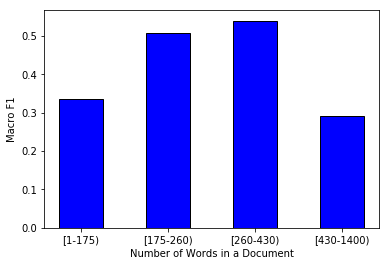

Positives
41
43
40
40
Neutrals
30
34
16
17
('oooonjaaa>>>', [['Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive'], ['Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Negative', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Neutral'], ['Neutral', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive'], ['Posi

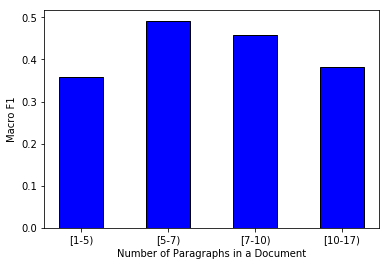

In [0]:
# maxes = [-1,3,5,7,9,11,13,15,1000]


plot_correctly_classified(splitter=' ',bar_range=[1,175,260,430,1400],label='Number of Words in a Document')
plot_correctly_classified(bar_range= [1,5,7,10,17])



pos: 
['Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral']
['Neutral', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Negative', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Positive']
['Neutral', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Negative', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Negative', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Negative']
['Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positiv

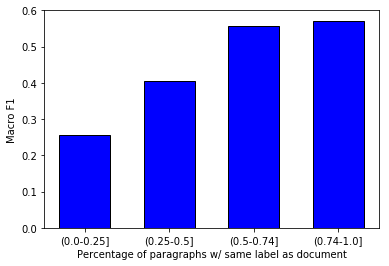

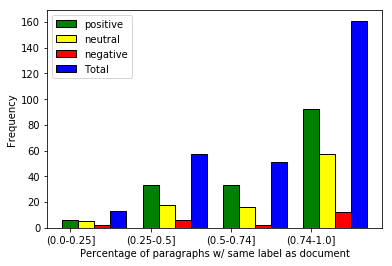

In [0]:
#### Plot percentage of paragraph in a document which has the same label as document vs macro f1 score

## input: set of documents with specific true label
## output: percentage of paragraphs in the input documents which has the same label as document
def par_in_doc(dev_par='',documents = negative_info,label ="Negative"):
  percent_neg_map = {}
  for doc_id in  documents.keys():
    neg_pars = list(dev_par[dev_par['doc_id']==doc_id]['sentiment'])
    if len(neg_pars)==0:
      percent_neg =1.
    else:
      percent_neg = float(neg_pars.count(label))/len(neg_pars)

    if percent_neg in percent_neg_map:
      percent_neg_map[percent_neg].append(documents[doc_id])
    else:
      percent_neg_map[percent_neg] = [documents[doc_id]]
#   print(len(percent_neg_map))
  return percent_neg_map

### based on the different ranges given, compute the f1 score of that specific category in each range ( percentage of paragraphs which has the same label as document)

def true_pred_cat(paragraphs = '', ranges = [0,0.26,0.51,0.67 ,0.80,1.],true_tag='Positive'):
  categories = [[] for _ in ranges[1:]]
#   print(len(paragraphs))
#   print(paragraphs)
#   for value,label in paragraphs:
  for key in paragraphs.keys():
    for i in range(1,len(ranges)):
      if key <= ranges[i] and key > ranges[i-1] :
        categories[i-1].extend(paragraphs[key])
  macro_f1 = []   
  data_distr = []
  for i in range(len(ranges[1:])):
    print(categories[i])
    macro_f1.append(float(categories[i].count(true_tag))/len(categories[i]))
    data_distr.append(len(categories[i]))
#   print(macro_f1)
  return macro_f1,categories,data_distr
  
per_po = par_in_doc(dev_par=dev_par,documents = positive_info,label ="Positive")
per_neu= par_in_doc(dev_par=dev_par,documents = neutral_info,label ="Neutral")
per_neg = par_in_doc(dev_par=dev_par,documents = negative_info,label ="Negative")
# print(par_po)
# print(par_neu)
# print(par_neg)



ranges = [0.,0.25,0.5,0.74,1.]
# ranges = [0,0.99,1.]
print('pos: ')
bar_pos,pos_val,data_distr_pos = true_pred_cat(paragraphs = per_po,ranges= ranges,true_tag='Positive')
print('neu: ')
bar_neu,neu_val,data_distr_neu  = true_pred_cat(paragraphs = per_neu,ranges= ranges,true_tag='Neutral')
print('neg: ')
bar_neg,neg_val,data_distr_neg = true_pred_cat(paragraphs = per_neg,ranges= ranges,true_tag='Negative')
print('total:')
for i in range(len(pos_val)):
  print(len(pos_val[i])+len(neu_val[i])+len(neg_val[i]))

bar_mac_f1 = [float(i+j+k)/3 for i,j,k in zip(bar_pos,bar_neu,bar_neg)]
print(bar_pos)
print(bar_neu)
print(bar_neg)
print(bar_mac_f1)
data_dist_total = [(i+j+k) for i,j,k in zip(data_distr_pos,data_distr_neu,data_distr_neg)]
bar_width = 0.2 
# plt.bar([i for i in range(1,len(ranges))], bar_pos, width = bar_width, color = 'green', edgecolor = 'black',  capsize=4, label='positive')
# plt.bar([i+bar_width for i in range(1,len(ranges))], bar_neu, width = bar_width, color = 'yellow', edgecolor = 'black', capsize=4, label='neutral')
# plt.bar([i+2*bar_width for i in range(1,len(ranges))], bar_neg, width = bar_width, color = 'red', edgecolor = 'black', capsize=4, label='negative')
plt.bar([i for i in range(1,len(ranges))], bar_mac_f1, width = 3*bar_width, color = 'blue', edgecolor = 'black', capsize=4, label='macroF1')


plt.xticks([r for r in range(1,len(ranges))], ['(%s-%s]'%(str(ranges[i]),str(ranges[i+1])) for i in range(len(ranges)-1)])#ranges[1:])
plt.ylabel('Macro F1')
plt.xlabel('Percentage of paragraphs w/ same label as document')
# plt.legend() 
plt.show()


# ### showing the dataset distribution
# plt.bar([i for i in range(1,len(ranges))], data_distr_pos, width = bar_width, color = 'green', edgecolor = 'black',  capsize=4, label='positive')
# plt.bar([i+bar_width for i in range(1,len(ranges))], data_distr_neu, width = bar_width, color = 'yellow', edgecolor = 'black', capsize=4, label='neutral')
# plt.bar([i+2*bar_width for i in range(1,len(ranges))], data_distr_neg, width = bar_width, color = 'red', edgecolor = 'black', capsize=4, label='negative')
# plt.bar([i+3*bar_width for i in range(1,len(ranges))], data_dist_total, width = bar_width, color = 'blue', edgecolor = 'black', capsize=4, label='Total')


# plt.xticks([r for r in range(1,len(ranges))], ['(%s-%s]'%(str(ranges[i]),str(ranges[i+1])) for i in range(len(ranges)-1)])#ranges[1:])
# plt.ylabel('Frequency')
# plt.xlabel('Percentage of paragraphs w/ same label as document')
# plt.legend() 
# plt.show()

Positives
68
52
43
Neutrals
41
30
24
('oooonjaaa>>>', [['Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Negative', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive'], ['Neutral', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Negative', 'Positive', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive'], ['Neutral', 'Neutral', 'Neutral', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 

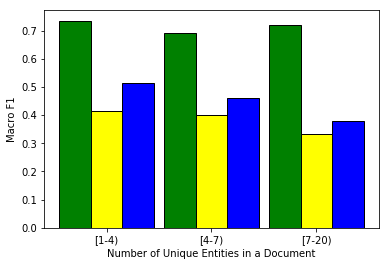

In [0]:
### number of unique entities vs Macro F1
plot_correctly_classified(splitter=' ',bar_range=[1,4,7,20],label='Number of Unique Entities in a Document',method_plot=unique_entity_label,plot='bar')
# plot_correctly_classified(splitter=' ',bar_range=[0,4,7,15],label='Number of Unique Entities in a Document',method_plot=unique_entity_label,plot='area')

{'pos_neg': [], 'neu_pos': [], 'neu_neg': [], 'pos_neu': [], 'neg_neu': [1929, 1933, 2062, 1944, 1969, 1842, 1976, 1852, 1985, 1884, 1900, 1902, 1907, 1908, 2046], 'neg_pos': [1844, 1854, 1984, 1875]}
(0.9058560924369748, 0.8454868231629963, {'neg_neu': 0.8522865299517116, 'neg_pos': 0.819987922705314})
{'pos_neg': [1943, 2014, 2028], 'neu_pos': [], 'neu_neg': [], 'pos_neu': [2050, 2052, 2055, 2066, 2071, 2073, 2077, 2078, 2079, 2086, 2089, 2091, 2095, 2098, 2103, 2108, 1822, 1866, 1873, 1881, 1890, 1905, 1906, 1910, 1919, 1920, 1931, 1934, 1952, 1961, 1974, 1982, 1997, 2002, 2004, 2013, 2016, 2020, 2024, 2026, 2031, 2039, 2042], 'neg_neu': [], 'neg_pos': []}
(0.8835872680262865, 0.8293638440213555, {'pos_neu': 0.8326637482048473, 'pos_neg': 0.7820652173913043})
{'pos_neg': [], 'neu_pos': [2048, 2075, 2080, 2084, 1831, 1838, 1839, 1840, 1845, 1848, 1850, 1855, 1857, 1861, 1862, 1864, 1869, 1871, 1874, 1889, 1892, 1893, 1895, 1896, 1897, 1898, 1911, 1912, 1921, 1949, 1950, 1955, 1957, 1

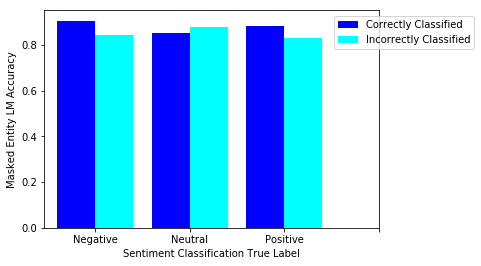

In [0]:
##### Compare the classification accuracy in sentiment analysis task and masked LM task
dev_predicted_masked = pd.read_csv(open('/content/dev_predicted.csv'))


### given and input list of document ids in the classification task, compute the accuracy of that set in masked lm task. it has three methods to compute average in masked lm task
### avg: which computes average among different documents, 
##  one: accuracy is one if one of the documents in masked lm is correctly classified, all: accuracy is one when all of the documents in masked lm is correctly classified
def compute_acc(input_list = [],method='avg'):
  
  cc_masked_lm_acc = 0   
  for doc_id in input_list:
    predicted = list(dev_predicted_masked[dev_predicted_masked['doc_id']==doc_id]['predicted'])
#     print(predicted)
    label = list(dev_predicted_masked[dev_predicted_masked['doc_id']==doc_id]['label'])
#     print(label)
    acc = metrics.accuracy_score(y_pred=predicted,y_true=label)
    if method == 'avg':
      cc_masked_lm_acc += acc
    elif method == 'all':
      if acc == 1:
        cc_masked_lm_acc +=1
    elif method == 'one':
      if acc > 0:
        cc_masked_lm_acc +=1
  return float(cc_masked_lm_acc/len(input_list))
        
### compare the masked lm accuracy with the sentiment analysis accuracy, given a label, return the correctly classified accuracy in masked lm and  
### incorrectly classified ( in sentiment analysis) accuracy ( in masked lm), as we have many documents in masked lm per each document in sentiment analysis,
### there are three methods to compute the accuracy in masked lm: 
###     avg: compute average accuracy among different documents with the same doc id in masked lm, 
###     all: if all of the documents aggree in masked lm that document is considered correct
###     one: if one of the documents is correctly classified in masked lm then that document is considered correct
def masked_LM_VS_classifier_acc(negative_info,label='Negative',method = 'avg'):
  correctly_classified= []
  incorrectly_classified = []
  incorrect_labels = {'neg_pos':[],'pos_neg':[],'pos_neu':[],
                     'neg_neu':[],'neu_pos':[],'neu_neg':[]}
  
  for item in negative_info:
    pred = negative_info[item] 
    if negative_info[item] ==label:
      correctly_classified.append(item)
    else:
      incorrectly_classified.append(item)
      if label.startswith('Neg') and pred.startswith('Po'):
        incorrect_labels['neg_pos'].append(item)
      elif label.startswith('Neg') and pred.startswith('Neu'):
        incorrect_labels['neg_neu'].append(item)
      elif label.startswith('Pos') and pred.startswith('Neg'):
        incorrect_labels['pos_neg'].append(item)

      elif label.startswith('Pos') and pred.startswith('Neu'):
        incorrect_labels['pos_neu'].append(item)

      elif label.startswith('Neu') and pred.startswith('Pos'):
        incorrect_labels['neu_pos'].append(item)

      elif label.startswith('Neu') and pred.startswith('Neg'):
        incorrect_labels['neu_neg'].append(item)

        
  print(incorrect_labels)
  cc_masked_lm_acc = compute_acc(correctly_classified,method=method)
    
  ic_masked_lm_acc = compute_acc(incorrectly_classified,method=method)
  incorrect_perclass_acc = {}
  for item in incorrect_labels:
    if len(incorrect_labels[item])==0:
      continue
    incorrect_perclass_acc[item] = compute_acc(incorrect_labels[item],method=method)

#   print(incorrect_perclass_acc)  
  return(cc_masked_lm_acc
               ,ic_masked_lm_acc,incorrect_perclass_acc)



cc_neg, ic_neg,incorrect_perclass_neg = masked_LM_VS_classifier_acc(negative_info,label='Negative',method='avg')
print(cc_neg, ic_neg,incorrect_perclass_neg)

cc_pos, ic_pos,incorrect_perclass_pos = masked_LM_VS_classifier_acc(positive_info,label='Positive',method='avg')
print(cc_pos, ic_pos,incorrect_perclass_pos)

cc_neu, ic_neu,incorrect_perclass_neu = masked_LM_VS_classifier_acc(neutral_info,label='Neutral',method='avg')
print(cc_neu, ic_neu,incorrect_perclass_neu)
fig, ax = plt.subplots()
index = np.arange(4)
bar_width = 0.4


# rect1 = plt.bar([i for i in range(3)], [cc_neg,incorrect_perclass_neu['neu_neg'],incorrect_perclass_pos['pos_neg']],bar_width,color = 'r',label='label_neg')
# rect2 = plt.bar([i+bar_width for i in range(3)], [incorrect_perclass_neg['neg_neu'],cc_neu,incorrect_perclass_pos['pos_neu']],bar_width,color = 'y',label='label_neu')
# rect3 = plt.bar([i+2*bar_width for i in range(3)], [incorrect_perclass_neg['neg_pos'],incorrect_perclass_neu['neu_pos'],cc_pos],bar_width,color = 'g',label='label_pos')
# rect4 = plt.bar([i+3*bar_width for i in range(3)], [ic_neg,ic_neu,ic_pos],bar_width,color = 'b',label='label_other')

rect1 = plt.bar([i for i in range(3)], [cc_neg,cc_neu,cc_pos],bar_width,color = 'blue',label='Correctly Classified')
rect2 = plt.bar([i+bar_width for i in range(3)], [ic_neg,ic_neu,ic_pos],bar_width,color = 'cyan',label='Incorrectly Classified')




# plt.tight_layout()
###loc: right, center left, upper right, lower right, best, center, lower left, center right, upper left, upper center, lower center

plt.legend(loc='right', bbox_to_anchor=(1.3, .9), ncol=1, fancybox=True, shadow=True)
# plt.legend()
plt.xticks( index+0.5*bar_width,('Negative','Neutral','Positive'))
plt.ylabel('Masked Entity LM Accuracy')
plt.xlabel('Sentiment Classification True Label')
plt.show()



In [0]:
cc_neu

0.8133068696860807

In [0]:
float(masked_lm_acc/len(correctly_classified))

0.878968253968254

#End of Error Analysis

In [0]:
tf.logging.set_verbosity(tf.logging.FATAL)
random_test_features = run_classifier.convert_examples_to_features(test_InputExamples_doc, label_list, MAX_SEQ_LENGTH, tokenizer)
fixed_test_features = run_classifier.convert_examples_to_features(test_InputExamples_fixed_doc, label_list, MAX_SEQ_LENGTH, tokenizer)
ind = 1
for ckpt in range(92,691,46):
  ind += 1
  print('----------------------starting epoch %d ----------------------'%ind)
  print('evaluating trainset: ')
  predictions = model_predict(estimator_from_tfhub,train_InputExamples_doc,train_features,checkpoint_path=OUTPUT_DIR+'/model.ckpt-%d'%ckpt)
  labels_val = []
  for item in predictions:
    labels_val.append(labels[np.argmax(item[1])])
  true_label = list(train_doc['sentiment'])
  print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
  print(metrics.classification_report(y_pred=labels_val,y_true = true_label))
  
  
  print('evaluating devset: ')
  
  predictions = model_predict(estimator_from_tfhub,eval_examples,eval_features,checkpoint_path=OUTPUT_DIR+'/model.ckpt-%d'%ckpt)
  labels_val = []
  for item in predictions:
    labels_val.append(labels[np.argmax(item[1])])
  true_label = list(dev_doc['sentiment'])
  print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
  print(metrics.classification_report(y_pred=labels_val,y_true = true_label))
  
  print('evaluating random testset: ')
  
  predictions = model_predict(estimator_from_tfhub,test_InputExamples_doc,random_test_features,checkpoint_path=OUTPUT_DIR+'/model.ckpt-%d'%ckpt)
  labels_val = []
  for item in predictions:
    labels_val.append(labels[np.argmax(item[1])])
  true_label = list(test_doc['sentiment'])
  print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
  print(metrics.classification_report(y_pred=labels_val,y_true = true_label))
    
  print('evaluating fixed testset: ')

  predictions = model_predict(estimator_from_tfhub,test_InputExamples_fixed_doc,fixed_test_features,checkpoint_path=OUTPUT_DIR+'/model.ckpt-%d'%ckpt)
  labels_val = []
  for item in predictions:
    labels_val.append(labels[np.argmax(item[1])])
  true_label = list(test_fixed_doc['sentiment'])
  print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
  print(metrics.classification_report(y_pred=labels_val,y_true = true_label))


----------------------starting epoch 2 ----------------------
evaluating trainset: 
[[  0   0 145]
 [  0   0 443]
 [  0   0 913]]
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       145
     Neutral       0.00      0.00      0.00       443
    Positive       0.61      1.00      0.76       913

   micro avg       0.61      0.61      0.61      1501
   macro avg       0.20      0.33      0.25      1501
weighted avg       0.37      0.61      0.46      1501

evaluating devset: 


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[  0   0  23]
 [  0   0  97]
 [  0   0 164]]
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        23
     Neutral       0.00      0.00      0.00        97
    Positive       0.58      1.00      0.73       164

   micro avg       0.58      0.58      0.58       284
   macro avg       0.19      0.33      0.24       284
weighted avg       0.33      0.58      0.42       284

evaluating random testset: 
[[  0   0  28]
 [  0   0  87]
 [  0   0 170]]
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        28
     Neutral       0.00      0.00      0.00        87
    Positive       0.60      1.00      0.75       170

   micro avg       0.60      0.60      0.60       285
   macro avg       0.20      0.33      0.25       285
weighted avg       0.36      0.60      0.45       285

evaluating fixed testset: 
[[  0   0  50]
 [  0   0 116]
 [  0   0 173]]
              precision    recall  f1-score  

In [0]:
# predictions = model_predict(estimator_from_tfhub,test_InputExamples_fixed_par)
# import numpy as np
# from sklearn import metrics
# labels = ["Negative","Neutral", "Positive"]
# labels_val = []
# for item in predictions:
#   labels_val.append(labels[np.argmax(item[1])])
# true_label = list(test_fixed_par['sentiment'])
# print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
# print(metrics.classification_report(y_pred=labels_val,y_true = true_label))
# predictions = model_predict(estimator_from_tfhub,test_InputExamples_par)
# labels_val = []
# for item in predictions:
#   labels_val.append(labels[np.argmax(item[1])])
# true_label = list(test_par['sentiment'])
# print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
# print(metrics.classification_report(y_pred=labels_val,y_true = true_label))





In [0]:
tf.logging.set_verbosity(tf.logging.FATAL)



print('-------- Document level Dev Result---------')
predictions = model_predict(estimator_from_tfhub,dev_InputExamples_doc)
labels_val = []
for item in predictions:
  labels_val.append(labels[np.argmax(item[1])])
true_label = list(dev_doc['sentiment'])
print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
print(metrics.classification_report(y_pred=labels_val,y_true = true_label))

print('-------- Document level Fixed Test Result---------')
predictions = model_predict(estimator_from_tfhub,test_InputExamples_fixed_doc)
labels_val = []
for item in predictions:
  labels_val.append(labels[np.argmax(item[1])])
true_label = list(test_fixed_doc['sentiment'])
print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
print(metrics.classification_report(y_pred=labels_val,y_true = true_label))

print('-------- Document level Random Test Result---------')
predictions = model_predict(estimator_from_tfhub,test_InputExamples_doc)
labels_val = []
for item in predictions:
  labels_val.append(labels[np.argmax(item[1])])
true_label = list(test_doc['sentiment'])
print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
print(metrics.classification_report(y_pred=labels_val,y_true = true_label))

-------- Document level Dev Result---------
[[  2  11  10]
 [  0  47  50]
 [  2  46 116]]
              precision    recall  f1-score   support

    Negative       0.50      0.09      0.15        23
     Neutral       0.45      0.48      0.47        97
    Positive       0.66      0.71      0.68       164

   micro avg       0.58      0.58      0.58       284
   macro avg       0.54      0.43      0.43       284
weighted avg       0.58      0.58      0.57       284

-------- Document level Fixed Test Result---------
[[  2  27  21]
 [  4  49  63]
 [  2  50 121]]
              precision    recall  f1-score   support

    Negative       0.25      0.04      0.07        50
     Neutral       0.39      0.42      0.40       116
    Positive       0.59      0.70      0.64       173

   micro avg       0.51      0.51      0.51       339
   macro avg       0.41      0.39      0.37       339
weighted avg       0.47      0.51      0.48       339

-------- Document level Random Test Result---------

In [0]:
tf.logging.set_verbosity(tf.logging.FATAL)

print('-------- Document level Dev Result---------')
predictions = model_predict(estimator_from_tfhub,dev_InputExamples_doc)
labels_val = []
for item in predictions:
  labels_val.append(labels[np.argmax(item[1])])
true_label = list(dev_doc['sentiment'])
print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
print(metrics.classification_report(y_pred=labels_val,y_true = true_label))

print('-------- Document level Fixed Test Result---------')
predictions = model_predict(estimator_from_tfhub,test_InputExamples_fixed_doc)
labels_val = []
for item in predictions:
  labels_val.append(labels[np.argmax(item[1])])
true_label = list(test_fixed_doc['sentiment'])
print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
print(metrics.classification_report(y_pred=labels_val,y_true = true_label))

print('-------- Document level Random Test Result---------')
predictions = model_predict(estimator_from_tfhub,test_InputExamples_doc)
labels_val = []
for item in predictions:
  labels_val.append(labels[np.argmax(item[1])])
true_label = list(test_doc['sentiment'])
print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
print(metrics.classification_report(y_pred=labels_val,y_true = true_label))

-------- Document level Dev Result---------
[[  2  15   6]
 [  0  48  49]
 [  2  52 110]]
              precision    recall  f1-score   support

    Negative       0.50      0.09      0.15        23
     Neutral       0.42      0.49      0.45        97
    Positive       0.67      0.67      0.67       164

   micro avg       0.56      0.56      0.56       284
   macro avg       0.53      0.42      0.42       284
weighted avg       0.57      0.56      0.55       284

-------- Document level Fixed Test Result---------
[[  3  28  19]
 [  5  53  58]
 [  2  60 111]]
              precision    recall  f1-score   support

    Negative       0.30      0.06      0.10        50
     Neutral       0.38      0.46      0.41       116
    Positive       0.59      0.64      0.61       173

   micro avg       0.49      0.49      0.49       339
   macro avg       0.42      0.39      0.38       339
weighted avg       0.47      0.49      0.47       339

-------- Document level Random Test Result---------

In [0]:
mds = []
evs = []
pds = []
tf.logging.set_verbosity(tf.logging.FATAL) 
for i in range(1,15):
  print('----------------------- Starting Epoch %d-----------------------'%i)

  NUM_TRAIN_EPOCHS = i
  
  num_train_steps = int(len(train_InputExamples_all) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
  num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

#   model_fn = model_fn_builder(
#   num_labels=len(label_list),
#   learning_rate=LEARNING_RATE,
#   num_train_steps=num_train_steps,
#   num_warmup_steps=num_warmup_steps,
#   use_tpu=True,
#   bert_hub_module_handle=BERT_MODEL_HUB)


  model_fn = model_fn_builder(
    num_labels=len(label_list),
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=True,
    bert_hub_module_handle=BERT_MODEL_HUB
  )

  estimator_from_tfhub = tf.contrib.tpu.TPUEstimator(
    use_tpu=True,
    model_fn=model_fn,
    config=get_run_config(OUTPUT_DIR),
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    predict_batch_size=PREDICT_BATCH_SIZE,
  )


  
  md = model_train(estimator_from_tfhub)
  
  
  print('-------- Document level Dev Result---------')
  predictions = model_predict(estimator_from_tfhub,dev_InputExamples_doc)
  labels_val = []
  for item in predictions:
    labels_val.append(labels[np.argmax(item[1])])
  true_label = list(dev_doc['sentiment'])
  print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
  print(metrics.classification_report(y_pred=labels_val,y_true = true_label))
  
  
  print('-------- Paragraph level Dev Result---------')
  predictions = model_predict(estimator_from_tfhub,dev_InputExamples_par)
  labels_val = []
  for item in predictions:
    labels_val.append(labels[np.argmax(item[1])])
  true_label = list(dev_par['sentiment'])
  print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
  print(metrics.classification_report(y_pred=labels_val,y_true = true_label))

  print('-------- Document level Fixed Test Result---------')
  predictions = model_predict(estimator_from_tfhub,test_InputExamples_fixed_doc)
  labels_val = []
  for item in predictions:
    labels_val.append(labels[np.argmax(item[1])])
  true_label = list(test_fixed_doc['sentiment'])
  print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
  print(metrics.classification_report(y_pred=labels_val,y_true = true_label))
  
  
  print('-------- Paragraph level Fixed Test Result---------')
  predictions = model_predict(estimator_from_tfhub,test_InputExamples_fixed_par)
  labels_val = []
  for item in predictions:
    labels_val.append(labels[np.argmax(item[1])])
  true_label = list(test_fixed_par['sentiment'])
  print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
  print(metrics.classification_report(y_pred=labels_val,y_true = true_label))

  print('-------- Document level Random Test Result---------')
  predictions = model_predict(estimator_from_tfhub,test_InputExamples_doc)
  labels_val = []
  for item in predictions:
    labels_val.append(labels[np.argmax(item[1])])
  true_label = list(test_doc['sentiment'])
  print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
  print(metrics.classification_report(y_pred=labels_val,y_true = true_label))
  
  print('-------- Paragraph level Random Test Result---------')
  predictions = model_predict(estimator_from_tfhub,test_InputExamples_par)
  labels_val = []
  for item in predictions:
    labels_val.append(labels[np.argmax(item[1])])
  true_label = list(test_par['sentiment'])
  print(metrics.confusion_matrix(y_pred=labels_val,y_true=true_label))
  print(metrics.classification_report(y_pred=labels_val,y_true = true_label))
  
  


----------------------- Starting Epoch 1-----------------------
***** Started training at 2019-05-09 12:07:13.408352 *****
  Num examples = 19178
  Batch size = 32
***** Finished training at 2019-05-09 12:11:33.467409 *****
-------- Document level Dev Result---------
[[  0  17   6]
 [  1  37  59]
 [  2  36 126]]
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        23
     Neutral       0.41      0.38      0.40        97
    Positive       0.66      0.77      0.71       164

   micro avg       0.57      0.57      0.57       284
   macro avg       0.36      0.38      0.37       284
weighted avg       0.52      0.57      0.55       284

-------- Paragraph level Dev Result---------
[[  1  92  53]
 [  1 317 437]
 [  4 244 732]]
              precision    recall  f1-score   support

    Negative       0.17      0.01      0.01       146
     Neutral       0.49      0.42      0.45       755
    Positive       0.60      0.75      0.66       9

284